# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [1]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [2]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [3]:
# Display the DataFrame
df = df_23Oct
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,00:00:00
1,2,1.0,NaN,NaN,02:20:00
2,3,1.0,1.0,NaN,00:55:00
3,4,NaN,1.0,NaN,00:00:00
4,5,1.0,NaN,NaN,00:00:00
...,...,...,...,...,...
116,117,2.0,NaN,NaN,01:05:00
117,118,1.0,NaN,NaN,01:35:00
118,119,NaN,1.0,NaN,01:35:00
119,120,NaN,1.0,NaN,00:00:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [4]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [5]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]}
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]}
            Passengers += 1
            transit_times.add(group[5])
            i+=1
    
    
Passengers 

{1: {'type': 1, 'group': 1, 'transit': inf},
 2: {'type': 0, 'group': 2, 'transit': inf},
 3: {'type': 0, 'group': 3, 'transit': 55.0},
 4: {'type': 1, 'group': 3, 'transit': 55.0},
 5: {'type': 1, 'group': 4, 'transit': inf},
 6: {'type': 0, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': 55.0},
 8: {'type': 1, 'group': 6, 'transit': 55.0},
 9: {'type': 1, 'group': 7, 'transit': inf},
 10: {'type': 1, 'group': 8, 'transit': 90.0},
 11: {'type': 1, 'group': 8, 'transit': 90.0},
 12: {'type': 1, 'group': 9, 'transit': inf},
 13: {'type': 1, 'group': 10, 'transit': inf},
 14: {'type': 0, 'group': 11, 'transit': inf},
 15: {'type': 1, 'group': 12, 'transit': inf},
 16: {'type': 0, 'group': 13, 'transit': 70.0},
 17: {'type': 0, 'group': 14, 'transit': 55.0},
 18: {'type': 1, 'group': 14, 'transit': 55.0},
 19: {'type': 1, 'group': 15, 'transit': inf},
 20: {'type': 0, 'group': 16, 'transit': inf},
 21: {'type': 0, 'group': 17, 'transit': inf},
 22: {'type': 0, 'group':

We define a dictionnary *Groups*, containing as keys the group ID and as valuea, the list of the members of the group

In [6]:
Groups = dict()


for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{3: [3, 4],
 6: [7, 8],
 8: [10, 11],
 14: [17, 18],
 26: [30, 31],
 27: [32, 33],
 28: [34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52],
 34: [58, 59],
 36: [61, 62],
 37: [63, 64],
 43: [70, 71],
 44: [72, 73],
 47: [76, 77, 78],
 55: [86, 87],
 62: [94, 95],
 63: [96, 97],
 65: [99, 100],
 66: [101, 102],
 67: [103, 104],
 72: [109, 110],
 76: [114, 115],
 79: [118, 119],
 80: [120, 121],
 85: [126, 127],
 91: [133, 134],
 107: [150, 151],
 109: [153, 154, 155, 156],
 112: [159, 160],
 115: [163, 164, 165],
 117: [167, 168],
 121: [172, 173]}

Definition of parameters necessary for the following steps

In [7]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #Aircraft model A320
else :
    number_of_rows = 35 #Aircraft model A321

number_of_columns = 7 # adding the aisle


## Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict_{i,j,k}$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [8]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


### The constraints 

- Every person has one seat

In [9]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [10]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [11]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [12]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [13]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [14]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Time Objectif

- Transit time

In [15]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [16]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 12.19                                                   



In [17]:
z_old = round(transit_obj.getValue(), 2)

- Transit time visualization

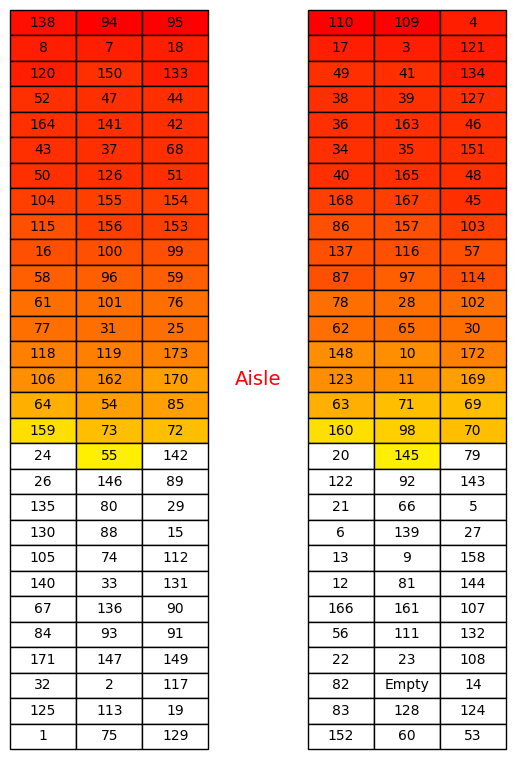

In [18]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Grouping Objectif

In [19]:
grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2)) \
                     for group in Groups.values() \
                     for k_1 in range(len(group)) \
                     for k_2 in range(k_1 + 1, len(group)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation


In [20]:

m.setParam(GRB.Param.TimeLimit, 600)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 320.9                                                   



- Grouping visualisation

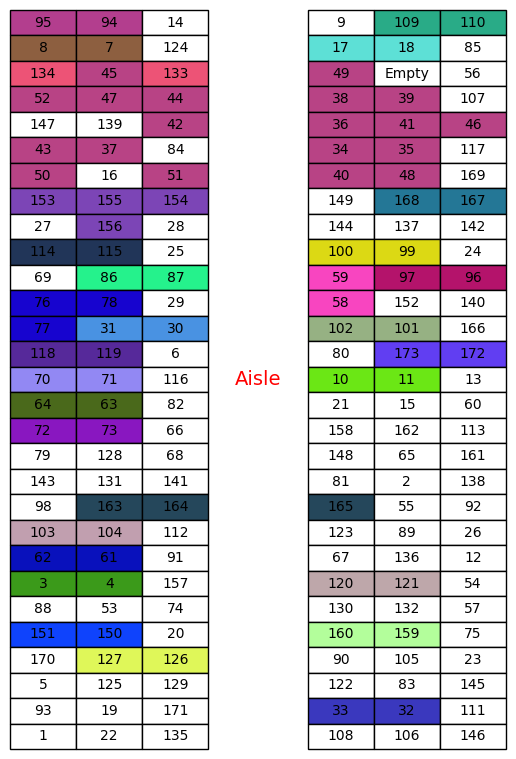

In [21]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Coupling both objectives

In [22]:
m.setObjective(0.7*grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

Set parameter OutputFlag to value 1


## Optimisation

In [23]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 600)  # Change to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 409 rows, 35119 columns and 215731 nonzeros
Model fingerprint: 0xb8a9e922
Model has 8611260 quadratic objective terms
Variable types: 0 continuous, 35119 integer (35119 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [3e-03, 2e-01]
  QObjective range [4e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective 230.048

Presolve removed 0 rows and 5017 columns (presolve time = 7s) ...
Presolve removed 60 rows and 5017 columns (presolve time = 70s) ...
Presolve removed 60 rows and 5017 columns
Presolve time: 69.93s
Presolved: 9552 rows, 39305 columns, 6454179 nonzeros
Variable types: 0 continuous, 39305 integer (30102

- Transit time visualisation

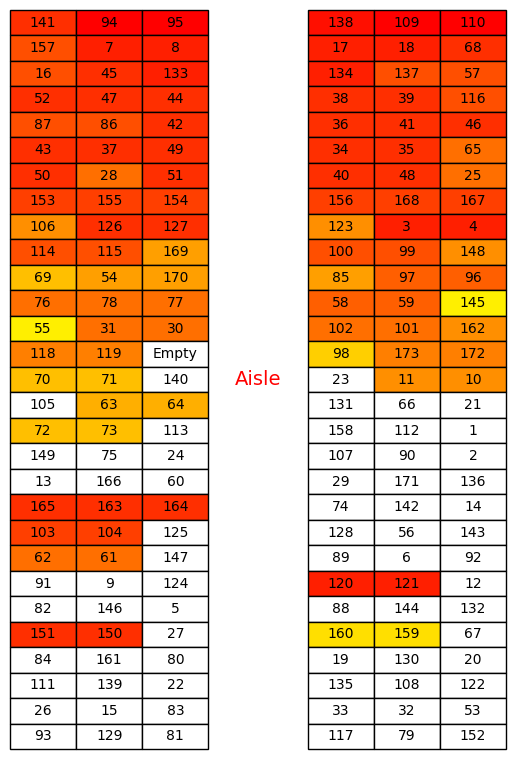

In [24]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

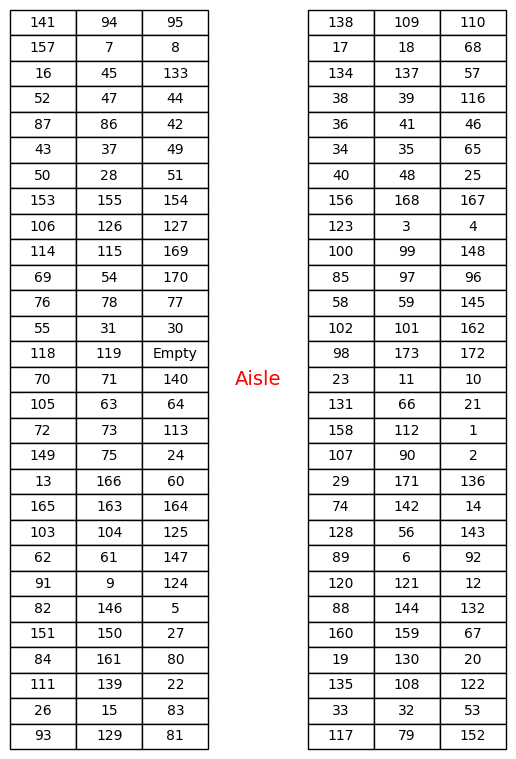

In [25]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Groups vizualisation

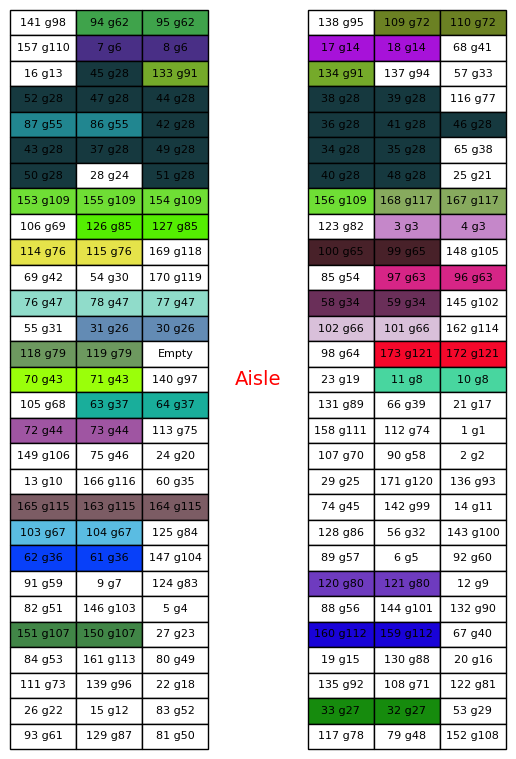

In [26]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Metrics

- Transit metric

In [27]:

z_new = round(transit_obj.getValue(), 2)


print("The satisfaction level related to transit time:", (1- (z_new- z_old)/z_old) * 100, " %" )

The satisfaction level related to transit time: 85.72600492206726  %


- Grouping metric

In [28]:
# TO DO